# Sesión 8: Validación Cruzada y Grid Search

## 🎯 Objetivos de la Sesión
- Entender los problemas del train/test split simple
- Dominar la validación cruzada y sus variaciones
- Implementar Grid Search para optimización de hiperparámetros
- Crear pipelines robustos que combinen preprocesamiento y modelado
- Comparar modelos de manera justa y rigurosa

---

## 📚 TEORÍA

### 1. Problemas del Train/Test Split Simple (8 min)

#### ¿Qué puede salir mal?

**Problema 1: Dependencia del Split Aleatorio**
```python
# Mismo modelo, diferentes resultados según la semilla
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Split 1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=42)
# Split 2  
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=99)
# ¿Cuál accuracy es el "real"?
```

**Problema 2: Desperdicio de Datos**
- Solo usamos ~70% para entrenar
- Solo evaluamos en ~30% de datos
- ¿Qué pasa si el test set no es representativo?

**Problema 3: Sobreajuste a los Hiperparámetros**
```python
# ¡MAL! Ajustamos hiperparámetros viendo el test set
best_k = None
best_score = 0
for k in [1, 3, 5, 7, 10]:
    model = KNeighborsClassifier(k)
    score = model.fit(X_train, y_train).score(X_test, y_test)
    if score > best_score:
        best_k = k  # ¡Hemos "visto" el test set!
```

### 2. Validación Cruzada: La Solución (12 min)

#### A. K-Fold Cross Validation

**Concepto básico:**
1. Dividir datos en K "folds" (pliegues)
2. Usar K-1 folds para entrenar, 1 fold para validar
3. Repetir K veces, rotando el fold de validación
4. Promediar los resultados

**Ejemplo visual con K=5:**
```
Fold 1: [TRAIN][TRAIN][TRAIN][TRAIN][TEST ]
Fold 2: [TRAIN][TRAIN][TRAIN][TEST ][TRAIN]
Fold 3: [TRAIN][TRAIN][TEST ][TRAIN][TRAIN]
Fold 4: [TRAIN][TEST ][TRAIN][TRAIN][TRAIN]
Fold 5: [TEST ][TRAIN][TRAIN][TRAIN][TRAIN]
```

**Ventajas:**
- Usa todos los datos para entrenar Y validar
- Estimación más robusta del rendimiento
- Reduce varianza de la estimación

#### B. Stratified K-Fold

**¿Por qué es necesario?**
- En K-Fold normal, los folds pueden tener distribuciones de clase diferentes
- Stratified mantiene la proporción de clases en cada fold

**Ejemplo:**
```
Dataset: 60% clase A, 40% clase B
Cada fold mantendrá: ~60% clase A, ~40% clase B
```

#### C. Otras Variaciones

**Leave-One-Out (LOO)**
- K = número de muestras
- Extremo: entrena con N-1, testa con 1
- Útil para datasets muy pequeños
- Costoso computacionalmente

**Time Series Split**
- Para datos temporales
- Respeta el orden cronológico
- No usa datos futuros para predecir el pasado

### 3. Grid Search: Optimización Automática (10 min)

#### ¿Qué son los Hiperparámetros?

**Parámetros del modelo** (se aprenden):
- Pesos en redes neuronales
- Coeficientes en regresión lineal

**Hiperparámetros** (los configuramos):
- K en KNN
- C y gamma en SVM
- Número de capas en red neuronal

#### Grid Search: Búsqueda Exhaustiva

**Concepto:**
1. Define grilla de hiperparámetros a probar
2. Entrena modelo con cada combinación
3. Evalúa cada combinación con validación cruzada
4. Selecciona la mejor combinación

**Ejemplo de grilla para SVM:**
```python
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}
# Total: 4 × 4 = 16 combinaciones
# Con CV de 5 folds: 16 × 5 = 80 modelos entrenados
```

### 4. Overfitting vs Underfitting Revisitado (5 min)

#### Definiciones Claras

**Underfitting (Subajuste):**
- Modelo demasiado simple
- Alto bias, bajo variance
- Performance mala en train Y test
- Solución: modelo más complejo

**Overfitting (Sobreajuste):**
- Modelo demasiado complejo
- Bajo bias, alto variance  
- Performance excelente en train, mala en test
- Solución: regularización, más datos, modelo más simple

#### Detección con Curvas de Aprendizaje
- Plot training score vs validation score
- Gap grande = overfitting
- Ambos scores bajos = underfitting

---


# Dataset: Breast Cancer Wisconsin 
## Paso 1: Validación Cruzada Manual

In [1]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (
    train_test_split, cross_val_score, 
    GridSearchCV, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Cargar datos
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

print("=== COMPARACIÓN: SPLIT SIMPLE vs VALIDACIÓN CRUZADA ===")

=== COMPARACIÓN: SPLIT SIMPLE vs VALIDACIÓN CRUZADA ===


In [2]:
def validacion_manual_vs_cv():
    """
    Comparar train/test split simple con validación cruzada
    """
    # Método 1: Split simple (método anterior)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    score_simple = knn.score(X_test_scaled, y_test)
    
    print(f"Método 1 - Train/Test Split: {score_simple:.4f}")
    
    # Método 2: Validación cruzada
    # Necesitamos incluir el escalado en cada fold
    scores_cv = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kfold.split(X, y):
        # Dividir datos
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Escalar (¡importante hacerlo en cada fold!)
        scaler_fold = StandardScaler()
        X_train_scaled = scaler_fold.fit_transform(X_train_fold)
        X_val_scaled = scaler_fold.transform(X_val_fold)
        
        # Entrenar y evaluar
        knn_fold = KNeighborsClassifier(n_neighbors=5)
        knn_fold.fit(X_train_scaled, y_train_fold)
        score = knn_fold.score(X_val_scaled, y_val_fold)
        scores_cv.append(score)
    
    print(f"Método 2 - Validación Cruzada:")
    print(f"  Scores por fold: {[f'{s:.4f}' for s in scores_cv]}")
    print(f"  Promedio: {np.mean(scores_cv):.4f} ± {np.std(scores_cv):.4f}")
    
    return scores_cv

scores_manual = validacion_manual_vs_cv()

Método 1 - Train/Test Split: 0.9591
Método 2 - Validación Cruzada:
  Scores por fold: ['0.9825', '0.9474', '0.9386', '0.9825', '0.9646']
  Promedio: 0.9631 ± 0.0179


## Paso 2: Validación Cruzada con Scikit-learn

In [3]:
def validacion_con_sklearn():
    """
    Usar las funciones integradas de sklearn para validación cruzada
    """
    print("\n=== VALIDACIÓN CRUZADA CON SKLEARN ===")
    
    # Crear pipeline que incluye escalado
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    
    # Validación cruzada automática
    scores = cross_val_score(
        pipeline, X, y, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy'
    )
    
    print(f"Scores con Pipeline: {[f'{s:.4f}' for s in scores]}")
    print(f"Promedio: {scores.mean():.4f} ± {scores.std():.4f}")
    
    # Comparar diferentes métricas
    metricas = ['accuracy', 'precision', 'recall', 'f1']
    print(f"\nComparación de métricas:")
    for metrica in metricas:
        scores_metric = cross_val_score(pipeline, X, y, cv=5, scoring=metrica)
        print(f"  {metrica:10s}: {scores_metric.mean():.4f} ± {scores_metric.std():.4f}")

validacion_con_sklearn()


=== VALIDACIÓN CRUZADA CON SKLEARN ===
Scores con Pipeline: ['0.9825', '0.9474', '0.9386', '0.9825', '0.9646']
Promedio: 0.9631 ± 0.0179

Comparación de métricas:
  accuracy  : 0.9649 ± 0.0096
  precision : 0.9623 ± 0.0187
  recall    : 0.9831 ± 0.0164
  f1        : 0.9723 ± 0.0074


## Paso 3: Grid Search Manual

In [4]:
def grid_search_manual():
    """
    Implementar Grid Search paso a paso para entender el proceso
    """
    print("\n=== GRID SEARCH MANUAL ===")
    
    # Definir grilla de parámetros para KNN
    param_grid = {
        'k': [1, 3, 5, 7, 10, 15, 20],
        'weights': ['uniform', 'distance']
    }
    
    # Preparar para almacenar resultados
    resultados = []
    
    # Búsqueda exhaustiva
    for k in param_grid['k']:
        for weights in param_grid['weights']:
            print(f"Probando k={k}, weights={weights}...")
            
            # Crear pipeline
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=k, weights=weights))
            ])
            
            # Validación cruzada
            scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
            mean_score = scores.mean()
            std_score = scores.std()
            
            # Guardar resultado
            resultados.append({
                'k': k,
                'weights': weights,
                'mean_score': mean_score,
                'std_score': std_score
            })
    
    # Convertir a DataFrame para análisis
    df_resultados = pd.DataFrame(resultados)
    
    # Encontrar mejores parámetros
    mejor_idx = df_resultados['mean_score'].idxmax()
    mejor_resultado = df_resultados.loc[mejor_idx]
    
    print(f"\n🏆 MEJORES PARÁMETROS:")
    print(f"  k = {mejor_resultado['k']}")
    print(f"  weights = {mejor_resultado['weights']}")
    print(f"  Score: {mejor_resultado['mean_score']:.4f} ± {mejor_resultado['std_score']:.4f}")
    
    return df_resultados

resultados_manual = grid_search_manual()


=== GRID SEARCH MANUAL ===
Probando k=1, weights=uniform...
Probando k=1, weights=distance...
Probando k=3, weights=uniform...
Probando k=3, weights=distance...
Probando k=5, weights=uniform...
Probando k=5, weights=distance...
Probando k=7, weights=uniform...
Probando k=7, weights=distance...
Probando k=10, weights=uniform...
Probando k=10, weights=distance...
Probando k=15, weights=uniform...
Probando k=15, weights=distance...
Probando k=20, weights=uniform...
Probando k=20, weights=distance...

🏆 MEJORES PARÁMETROS:
  k = 7
  weights = uniform
  Score: 0.9701 ± 0.0089


# Paso 4: Grid Search Automático con Scikit-learn

In [5]:
def grid_search_sklearn():
    """
    Usar GridSearchCV de sklearn para automatizar la búsqueda
    """
    print("\n=== GRID SEARCH CON SKLEARN ===")
    
    # Crear pipeline base
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])
    
    # Definir grilla de parámetros
    # Nota: usamos prefijo 'knn__' para parámetros del clasificador
    param_grid = {
        'knn__n_neighbors': [1, 3, 5, 7, 10, 15, 20],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan']
    }
    
    # Crear GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,  # Usar todos los cores disponibles
        verbose=1   # Mostrar progreso
    )
    
    # Ejecutar búsqueda
    print("Ejecutando Grid Search...")
    grid_search.fit(X, y)
    
    # Mostrar resultados
    print(f"\n🏆 MEJORES PARÁMETROS:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nBest Score: {grid_search.best_score_:.4f}")
    
    # Analizar top 5 mejores combinaciones
    print(f"\n📊 TOP 5 MEJORES COMBINACIONES:")
    resultados_cv = pd.DataFrame(grid_search.cv_results_)
    top_5 = resultados_cv.nlargest(5, 'mean_test_score')[
        ['mean_test_score', 'std_test_score', 'params']
    ]
    
    for i, (idx, row) in enumerate(top_5.iterrows(), 1):
        print(f"{i}. Score: {row['mean_test_score']:.4f} ± {row['std_test_score']:.4f}")
        print(f"   Params: {row['params']}")
    
    return grid_search

grid_search_result = grid_search_sklearn()


=== GRID SEARCH CON SKLEARN ===
Ejecutando Grid Search...
Fitting 5 folds for each of 28 candidates, totalling 140 fits

🏆 MEJORES PARÁMETROS:
  knn__metric: euclidean
  knn__n_neighbors: 7
  knn__weights: distance

Best Score: 0.9666

📊 TOP 5 MEJORES COMBINACIONES:
1. Score: 0.9666 ± 0.0161
   Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}
2. Score: 0.9666 ± 0.0171
   Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
3. Score: 0.9666 ± 0.0171
   Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
4. Score: 0.9666 ± 0.0188
   Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
5. Score: 0.9666 ± 0.0188
   Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


# Paso 5: Comparación de Múltiples Algoritmos

In [6]:
def comparar_multiples_algoritmos():
    """
    Comparar diferentes algoritmos usando validación cruzada
    """
    print("\n=== COMPARACIÓN DE ALGORITMOS ===")
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    
    # Definir modelos con sus mejores parámetros conocidos
    modelos = {
        'KNN': Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=5))
        ]),
        'SVM': Pipeline([
            ('scaler', StandardScaler()),
            ('svm', SVC(C=1, gamma='scale', random_state=42))
        ]),
        'Random Forest': Pipeline([
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
        ]),
        'Logistic Regression': Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(random_state=42, max_iter=1000))
        ])
    }
    
    # Evaluar cada modelo
    resultados_comparacion = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for nombre, modelo in modelos.items():
        print(f"Evaluando {nombre}...")
        
        # Múltiples métricas
        metricas = ['accuracy', 'precision', 'recall', 'f1']
        resultados_modelo = {}
        
        for metrica in metricas:
            scores = cross_val_score(modelo, X, y, cv=cv, scoring=metrica)
            resultados_modelo[metrica] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
        
        resultados_comparacion[nombre] = resultados_modelo
    
    # Crear tabla comparativa
    print(f"\n📊 TABLA COMPARATIVA:")
    print(f"{'Modelo':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 68)
    
    for nombre, metricas in resultados_comparacion.items():
        acc = metricas['accuracy']
        prec = metricas['precision']
        rec = metricas['recall']
        f1 = metricas['f1']
        
        print(f"{nombre:<20} "
              f"{acc['mean']:.3f}±{acc['std']:.3f}   "
              f"{prec['mean']:.3f}±{prec['std']:.3f}   "
              f"{rec['mean']:.3f}±{rec['std']:.3f}   "
              f"{f1['mean']:.3f}±{f1['std']:.3f}")
    
    return resultados_comparacion

resultados_comp = comparar_multiples_algoritmos()


=== COMPARACIÓN DE ALGORITMOS ===
Evaluando KNN...
Evaluando SVM...
Evaluando Random Forest...
Evaluando Logistic Regression...

📊 TABLA COMPARATIVA:
Modelo               Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------
KNN                  0.963±0.018   0.957±0.026   0.986±0.012   0.971±0.014
SVM                  0.977±0.016   0.976±0.022   0.989±0.011   0.982±0.013
Random Forest        0.956±0.012   0.965±0.028   0.966±0.027   0.965±0.010
Logistic Regression  0.974±0.017   0.968±0.029   0.992±0.011   0.979±0.013



=== VISUALIZACIÓN DE RESULTADOS ===


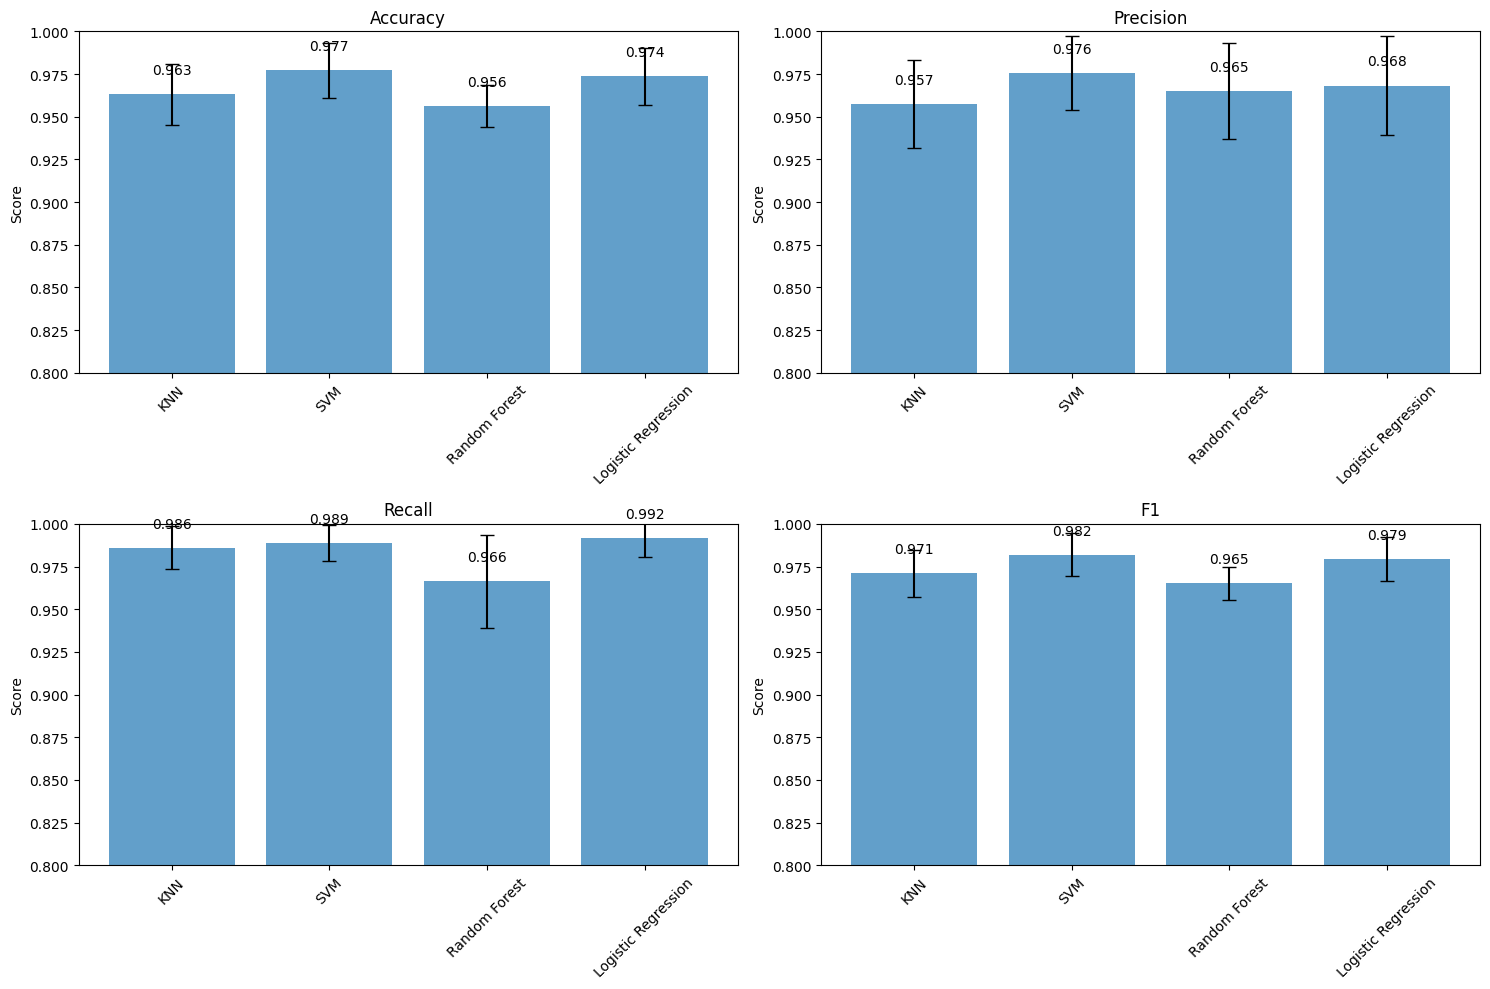

In [7]:
def visualizar_comparacion(resultados_comparacion):
    """
    Crear visualizaciones de la comparación de modelos
    """
    print("\n=== VISUALIZACIÓN DE RESULTADOS ===")
    
    # Preparar datos para plotting
    modelos = list(resultados_comparacion.keys())
    metricas = ['accuracy', 'precision', 'recall', 'f1']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, metrica in enumerate(metricas):
        ax = axes[i]
        
        # Extraer scores para cada modelo
        medias = []
        errores = []
        
        for modelo in modelos:
            media = resultados_comparacion[modelo][metrica]['mean']
            std = resultados_comparacion[modelo][metrica]['std']
            medias.append(media)
            errores.append(std)
        
        # Crear gráfico de barras con error bars
        bars = ax.bar(modelos, medias, yerr=errores, capsize=5, alpha=0.7)
        ax.set_title(f'{metrica.capitalize()}')
        ax.set_ylabel('Score')
        ax.set_ylim(0.8, 1.0)  # Ajustar según datos
        
        # Rotar etiquetas del eje x
        ax.set_xticklabels(modelos, rotation=45)
        
        # Añadir valores en las barras
        for bar, media in zip(bars, medias):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{media:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

visualizar_comparacion(resultados_comp)

# Paso 6: Pipeline Completo y Validación Final

In [8]:
def pipeline_completo_final():
    """
    Crear un pipeline completo desde exploración hasta evaluación final
    """
    print("\n=== PIPELINE COMPLETO DE MACHINE LEARNING ===")
    
    # Paso 1: Dividir datos en train+val y test final
    X_temp, X_test_final, y_temp, y_test_final = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Datos para desarrollo: {X_temp.shape[0]} muestras")
    print(f"Datos para test final: {X_test_final.shape[0]} muestras")
    
    # Paso 2: Grid Search en datos de desarrollo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(random_state=42))
    ])
    
    param_grid = {
        'svm__C': [0.1, 1, 10],
        'svm__gamma': ['scale', 'auto', 0.01, 0.1],
        'svm__kernel': ['rbf', 'linear']
    }
    
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1
    )
    
    print("Buscando mejores hiperparámetros...")
    grid_search.fit(X_temp, y_temp)
    
    print(f"Mejores parámetros: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    
    # Paso 3: Evaluación final en test set no visto
    mejor_modelo = grid_search.best_estimator_
    score_final = mejor_modelo.score(X_test_final, y_test_final)
    
    print(f"\n🎯 EVALUACIÓN FINAL:")
    print(f"Score en test set final: {score_final:.4f}")
    
    # Paso 4: Reporte detallado
    y_pred_final = mejor_modelo.predict(X_test_final)
    print(f"\nReporte de clasificación final:")
    print(classification_report(y_test_final, y_pred_final, 
                               target_names=cancer.target_names))

pipeline_completo_final()


=== PIPELINE COMPLETO DE MACHINE LEARNING ===
Datos para desarrollo: 455 muestras
Datos para test final: 114 muestras
Buscando mejores hiperparámetros...
Mejores parámetros: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Best CV Score: 0.9844

🎯 EVALUACIÓN FINAL:
Score en test set final: 0.9825

Reporte de clasificación final:
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114




## 📊 Resumen de la Sesión

### Conceptos Clave Aprendidos:

1. **Validación Cruzada**:
   - Solución robusta a la dependencia del split aleatorio
   - Mejor uso de los datos disponibles
   - Estimación más confiable del rendimiento

2. **Grid Search**:
   - Búsqueda sistemática de hiperparámetros
   - Automatización del proceso de optimización
   - Prevención del overfitting a los hiperparámetros

3. **Pipelines**:
   - Encadenar preprocesamiento y modelado
   - Prevenir data leakage
   - Código más limpio y reproducible

4. **Buenas Prácticas**:
   - Siempre usar stratified k-fold para clasificación
   - Incluir preprocesamiento en el pipeline
   - Reservar conjunto de test final para evaluación única

### Workflow Recomendado:
1. **Exploración inicial** con split simple
2. **Desarrollo del modelo** con validación cruzada
3. **Optimización** con grid search
4. **Evaluación final** en test set no visto
---

**💡 Tip profesional**: La validación cruzada es estándar en la industria. Cualquier modelo que reportes sin CV será cuestionado por su robustez.

### Para la Próxima Sesión:
En el **Módulo 4** comenzaremos con casos prácticos avanzados, aplicando todo lo aprendido a problemas reales como **Computer Vision** y **Detección de Malware**.